# QF627 Project

###### Prepared By:
Haozeh Zhuo  
Gabriel Woon  
Shuo Xiao  
Yong Wen Wong  

# Activate Libraries

In [1]:
# Modules
import numpy as np
import pandas as pd

import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas_datareader.data as pdr
import yfinance as yf

import warnings

# Settings
np.set_printoptions(precision = 5)

pd.set_option("precision", 5)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

warnings.filterwarnings("ignore")

# Datetime

In [2]:
# Datetime
start = dt.datetime(2002, 11, 1)
end = dt.datetime(2021, 10, 31)

# SPY Data

In [3]:
# SPY Data
SPY = pdr.get_data_yahoo("SPY",
                        start,
                        end)

In [4]:
# Investment Timeframe
D = (SPY.index[-1] - SPY.index[0]).days

In [5]:
# Capital Allocated
Capital = 500000

In [6]:
# Calculate SPY Daily Returns
SPY["Returns"] = np.log(SPY["Adj Close"] / SPY["Adj Close"].shift(1))
SPY["Direction"] = np.where(SPY["Returns"] > 0, 1, 0)
SPY.dropna(inplace = True)

In [7]:
# Calculate SPY Sharpe
SPY_Sharpe = np.sqrt(253)*SPY["Returns"].mean()/SPY["Returns"].std()

In [8]:
# Calculate SPY CAGR
SPY_CAGR = (((SPY["Adj Close"][-1]) / (SPY["Adj Close"][1])) ** (365.0/D)) - 1

In [9]:
# Calculate SPY Money Left
SPY_MoneyLeft = SPY["Returns"].cumsum().apply(np.exp)[-1]*Capital

In [10]:
# Calculate SPY Max Drawdown
SPY["Cumulative"] = SPY["Returns"].cumsum().apply(np.exp)
SPY["Max_Gross_Performance"] = SPY["Cumulative"].cummax()
SPY_Drawdown = (SPY["Max_Gross_Performance"] - SPY["Cumulative"]).max()
SPY_Cumulative = SPY["Cumulative"][-1]

In [11]:
# SPY Statistics
SPY_Stats = pd.DataFrame([SPY_Sharpe, SPY_CAGR, SPY_Cumulative, SPY_MoneyLeft, SPY_Drawdown])
SPY_Stats = SPY_Stats.T
SPY_Stats.columns = ['Sharpe', 'CAGR', "Cumulative", "Money Left", "Max Drawdown"]
SPY_Stats = SPY_Stats.rename(index={0: "SPY"})
SPY_Stats

,Sharpe,CAGR,Cumulative,Money Left,Max Drawdown
SPY,0.563,0.110,7.504,3751839.448,1.812


# Momentum Strategy - M1 (Long SMA, Short SMA)
<a id="Momentum Strategy"></a>

In [12]:
# Momentum Parameters
SPY1 = SPY.copy()
data = [0]
SharpeM1 = pd.DataFrame(data, columns=['Empty'])
CumulativeM1 = pd.DataFrame(data, columns=['Empty'])
CAGRM1 = pd.DataFrame(data, columns=['Empty'])
MoneyLeftM1 = pd.DataFrame(data, columns=['Empty'])
DrawDownM1 = pd.DataFrame(data, columns=['Empty'])

In [13]:
# Momentum Strategy Developement
## n = long SMA
## m = short SMA

for n in range(126, 253):
    for m in range(126,253):
        if n > m:

                SPY1["SMA_L(%d)" % n] = SPY1["Adj Close"].rolling(window = n).mean()
    
                SPY1["SMA_S(%d)" % n] = SPY1["Adj Close"].rolling(window = m).mean()
    
                SPY1["Position(%d_%d)" % (n, m)] = np.where(SPY1["SMA_S(%d)" % n] < SPY1["SMA_L(%d)" % n],
                                                            -1, 
                                                            1)
             
                SPY1["Strategy(%d_%d)" % (n, m)] = SPY1["Position(%d_%d)" % (n, m)].shift(1) * SPY1["Returns"]
        
                try:
                    SharpeM1["M1(%d_%d)" % (n, m)] = (np.sqrt(253)) * (SPY1["Strategy(%d_%d)" % (n, m)].mean()/SPY1["Strategy(%d_%d)" % (n, m)].std())
                
                except:
                    pass
        
                CAGRM1["M1(%d_%d)" % (n, m)] = ((SPY1["Strategy(%d_%d)" % (n, m)].cumsum().apply(np.exp)[-1] / 1) ** (365.0/D)) - 1
        
                CumulativeM1["M1(%d_%d)" % (n, m)] = SPY1["Strategy(%d_%d)" % (n, m)].cumsum().apply(np.exp)[-1]
        
                MoneyLeftM1["M1(%d_%d)" % (n, m)] = SPY1["Strategy(%d_%d)" % (n, m)].cumsum().apply(np.exp)[-1]*Capital
        
                DrawDownM1["M1(%d_%d)" % (n, m)] = (SPY1["Strategy(%d_%d)" % (n, m)].cumsum().apply(np.exp).cummax() - SPY1["Strategy(%d_%d)" % (n, m)].cumsum().apply(np.exp)).max()
               
        else:
            pass

In [14]:
# Momentum Statistics
M1 = SharpeM1.append(CAGRM1)
M1 = M1.append(CumulativeM1)
M1 = M1.append(MoneyLeftM1)
M1 = M1.append(DrawDownM1)
M1 = M1.T.copy()
M1.columns = ['Sharpe', 'CAGR', 'Cumulative', "Money Left", "Max Drawdown"]
M1 = pd.concat([M1, SPY_Stats])
M1 = M1.rename(index={0: "SPY"})

# Replace 0 with NaN
M1 = M1.replace(to_replace={
                           'Sharpe':{0:np.nan}, 
                           'CAGR':{0:np.nan},
                           'Cumulative':{0:np.nan},
                           'Money Left':{0:np.nan},
                           'Max Drawdown':{0:np.nan},
                           })

In [15]:
# Top & Bottom Momentum Strategies
M1.sort_values(by="Cumulative", ascending=False)

,Sharpe,CAGR,Cumulative,Money Left,Max Drawdown
M1(252_157),0.651,0.130,10.248,5123754.024,2.080
M1(246_159),0.641,0.128,9.909,4954496.372,2.055
M1(152_151),0.639,0.128,9.820,4910165.310,2.623
M1(247_158),0.636,0.127,9.713,4856515.632,2.028
M1(245_159),0.628,0.125,9.457,4728499.175,1.962
...,...,...,...,...,...
M1(144_139),0.124,0.024,1.560,780061.475,0.800
M1(143_142),0.094,0.018,1.402,700960.484,0.707
M1(144_140),0.081,0.015,1.337,668537.224,0.701
M1(144_142),0.078,0.015,1.320,660128.006,0.700


In [16]:
# Momentum Max Strategy
M1.idxmax()

Sharpe          M1(252_157)
CAGR            M1(252_157)
Cumulative      M1(252_157)
Money Left      M1(252_157)
Max Drawdown    M1(222_221)
dtype: object

In [17]:
# Momentum Min Strategy
M1.idxmin()

Sharpe          M1(144_142)
CAGR            M1(144_142)
Cumulative      M1(144_142)
Money Left      M1(144_142)
Max Drawdown    M1(146_142)
dtype: object

In [18]:
# Momentum Best Strategy Statistics
M1_Best = M1.loc[["M1(248_158)","SPY"]]; M1_Best

,Sharpe,CAGR,Cumulative,Money Left,Max Drawdown
M1(248_158),0.624,0.125,9.309,4654297.951,1.888
SPY,0.563,0.110,7.504,3751839.448,1.812


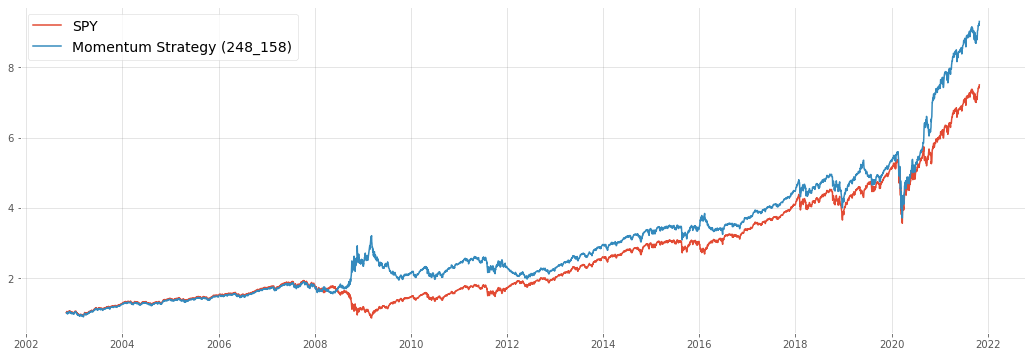

In [19]:
# Plot Momentum Best Strategy Cumulative Returns
figure(figsize=(18, 6))
plt.plot(SPY1[['Returns','Strategy(248_158)']].cumsum().apply(np.exp))
plt.legend(["SPY","Momentum Strategy (248_158)"])

# Mean Reversion Strategy - MR1 (SMA, Threshold, Threshold Multiplier)

In [20]:
# Mean Reversion Parameters
SPY2 = SPY.copy()
data = [0]
SharpeMR1 = pd.DataFrame(data, columns=['Empty'])
CAGRMR1 = pd.DataFrame(data, columns=['Empty'])
CumulativeMR1 = pd.DataFrame(data, columns=['Empty'])
MoneyLeftMR1 = pd.DataFrame(data, columns=['Empty'])
DrawDownMR1 = pd.DataFrame(data, columns=['Empty'])

In [21]:
# Mean Reversion Strategy Developement
## n = SMA
## m = Threshold
## i = Threshold Multiplier

for n in range(1, 64):
    for m in range(1, 64):
        for i in range(1,3):
    
            SPY2["SMA(%d)" % n] = SPY2["Adj Close"].rolling(window = n).mean()
    
            SPY2["T(%d%d)" % (m, i)] = i*SPY2["Adj Close"].rolling(window = m).std()
    
            SPY2["-T(%d%d)" % (m, i)] = -1*SPY2["T(%d%d)" % (m, i)]
    
            SPY2["Dist(%d)" % n] = SPY2["Adj Close"] - SPY2["SMA(%d)" % n]
    
            SPY2["Position(%d_%d_%d)" % (n, m, i)] = np.where(SPY2["Dist(%d)" % n] > SPY2["T(%d%d)" % (m, i)],
                                                             -1, np.nan)
        
            SPY2["Position(%d_%d_%d)" % (n, m, i)] = np.where(SPY2["Dist(%d)" % n] < SPY2["-T(%d%d)" % (m, i)],
                                                             1, SPY2["Position(%d_%d_%d)" % (n, m, i)])
        
            SPY2["Position(%d_%d_%d)" % (n, m, i)] = np.where(SPY2["Dist(%d)" % n] * SPY2["Dist(%d)" % n].shift(1) < 0, 
                                                             0,  SPY2["Position(%d_%d_%d)" % (n, m, i)])
        
            SPY2["Position(%d_%d_%d)" % (n, m, i)] = SPY2["Position(%d_%d_%d)" % (n, m, i)].ffill()

            SPY2["Position(%d_%d_%d)" % (n, m, i)] = SPY2["Position(%d_%d_%d)" % (n, m, i)].fillna(0)
        
            SPY2["Strategy(%d_%d_%d)" % (n, m, i)] = SPY2["Position(%d_%d_%d)" % (n, m, i)].shift(1) * SPY2["Returns"]
        
            try:
                SharpeMR1["MR1(%d_%d_%d)" % (n, m, i)] = (np.sqrt(253)) * (SPY2["Strategy(%d_%d_%d)" % (n, m, i)].mean()/SPY2["Strategy(%d_%d_%d)" % (n, m, i)].std())
            
            except:
                pass
        
            CAGRMR1["MR1(%d_%d_%d)" % (n, m, i)] = ((SPY2["Strategy(%d_%d_%d)" % (n, m, i)].cumsum().apply(np.exp)[-1] / 1) ** (365.0/D)) - 1
        
            CumulativeMR1["MR1(%d_%d_%d)" % (n, m, i)] = SPY2["Strategy(%d_%d_%d)" % (n, m, i)].cumsum().apply(np.exp)[-1]
        
            MoneyLeftMR1["MR1(%d_%d_%d)" % (n, m, i)] = SPY2["Strategy(%d_%d_%d)" % (n, m, i)].cumsum().apply(np.exp)[-1]*Capital
        
            DrawDownMR1["MR1(%d_%d_%d)" % (n, m, i)] = (SPY2["Strategy(%d_%d_%d)" % (n, m, i)].cumsum().apply(np.exp).cummax() - SPY2["Strategy(%d_%d_%d)" % (n, m, i)].cumsum().apply(np.exp)).max()

In [22]:
# Mean Reversion Statistics
MR1 = SharpeMR1.append(CAGRMR1)
MR1 = MR1.append(CumulativeMR1)
MR1 = MR1.append(MoneyLeftMR1)
MR1 = MR1.append(DrawDownMR1)
MR1 = MR1.T.copy()
MR1.columns = ['Sharpe', 'CAGR', 'Cumulative', "Money Left", "Max Drawdown"]
MR1 = pd.concat([MR1, SPY_Stats])
MR1 = MR1.rename(index={0: "SPY"})

# Replace 0 with NaN
MR1 = MR1.replace(to_replace={
                             'Sharpe':{0:np.nan}, 
                             'CAGR':{0:np.nan},
                             'Cumulative':{0:np.nan},
                             'Money Left':{0:np.nan},
                             'Max Drawdown':{0:np.nan},
                             })

In [23]:
# Top & Bottom Mean Reversion Strategies
MR1.sort_values(by="Cumulative", ascending=False)

,Sharpe,CAGR,Cumulative,Money Left,Max Drawdown
SPY,0.563,0.110,7.504,3751839.448,1.812
MR1(4_4_1),0.494,0.074,3.865,1932406.218,1.332
MR1(8_5_1),0.434,0.071,3.701,1850460.540,1.962
MR1(8_14_1),0.432,0.068,3.497,1748326.910,1.817
MR1(4_3_1),0.449,0.068,3.485,1742310.721,1.104
...,...,...,...,...,...
MR1(63_6_2),-0.241,-0.041,0.452,226235.517,0.599
MR1(61_3_2),-0.236,-0.041,0.452,226186.214,0.659
MR1(59_6_2),-0.245,-0.041,0.449,224546.447,0.601
MR1(63_3_2),-0.239,-0.042,0.446,223079.400,0.645


In [24]:
# Mean Reversion Max Strategy
MR1.idxmax()

Sharpe          MR1(3_11_2)
CAGR                    SPY
Cumulative              SPY
Money Left              SPY
Max Drawdown    MR1(10_5_1)
dtype: object

In [25]:
# Mean Reversion Min Strategy
MR1.idxmin()

Sharpe           MR1(2_6_1)
CAGR            MR1(63_3_2)
Cumulative      MR1(63_3_2)
Money Left      MR1(63_3_2)
Max Drawdown     MR1(3_9_2)
dtype: object

In [26]:
# Mean Reversion Best Strategy Statistics
MR1_Best = MR1.loc[["MR1(4_4_1)","SPY"]]; MR1_Best

,Sharpe,CAGR,Cumulative,Money Left,Max Drawdown
MR1(4_4_1),0.494,0.074,3.865,1932406.218,1.332
SPY,0.563,0.110,7.504,3751839.448,1.812


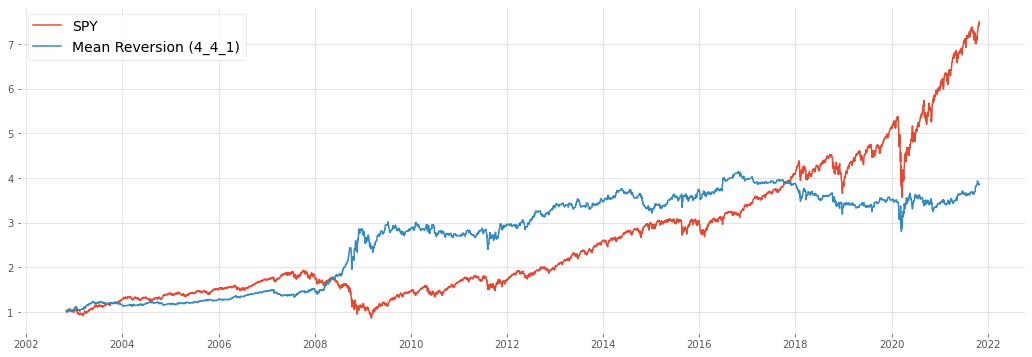

In [27]:
# Plot Mean Reversion Best Strategy Cumulative Returns
figure(figsize=(18, 6))
plt.plot(SPY2[['Returns','Strategy(4_4_1)']].cumsum().apply(np.exp))
plt.legend(["SPY","Mean Reversion (4_4_1)"])

# Machine Learning Strategy - ML1

In [28]:
# Machine Learning Modules 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [29]:
# Machine Learning Parameters
SPY3 = SPY.copy()
data = [0]
SharpeML1 = pd.DataFrame(data, columns=['Empty'])
CAGRML1 = pd.DataFrame(data, columns=['Empty'])
CumulativeML1 = pd.DataFrame(data, columns=['Empty'])
MoneyLeftML1 = pd.DataFrame(data, columns=['Empty'])
DrawDownML1 = pd.DataFrame(data, columns=['Empty'])

In [30]:
# Machine Learning Lags Variables
## Lag Variables = Arbitrary

LAGS = 5
COLS = []

for LAG in range(1, LAGS +1):
    COL = "lag_{}".format(LAG)
    SPY3[COL] = SPY3["Returns"].shift(LAG)
    COLS.append(COL)
    
SPY3.dropna(inplace = True)

In [31]:
# Machine Learning Models
names = []
models = []

models.append(("LR", LinearRegression()))

models.append(("LASSO", Lasso()))

models.append(("EN", ElasticNet()))

models.append(("CART", DecisionTreeRegressor()))

models.append(("KNN", KNeighborsRegressor()))

models.append(("SVR", SVR()))

models.append(("MLP", MLPRegressor()))

models.append(("ETR", ExtraTreesRegressor()))

models.append(("RFR", RandomForestRegressor()))

models.append(("GBR", GradientBoostingRegressor()))

models.append(("ABR", AdaBoostRegressor()))

In [32]:
# Machine Learning Strategy Developement
for name, model in models:
    
    names.append(name)
    
    model.fit(SPY3[COLS], SPY3["Returns"])
    
    SPY3["Learning(%s)" % name] = model.predict(SPY3[COLS])
    
    SPY3["Prediction(%s)" % name] = np.where(model.predict(SPY3[COLS]) > 0,
                                             1, 
                                            -1)
        
    SPY3["Strategy(%s)" % name] = SPY3["Prediction(%s)" % name] * SPY3["Returns"]
    
    try:
        SharpeML1["ML1(%s)" % name] = (np.sqrt(253)) * (SPY3["Strategy(%s)" % name].mean()/SPY3["Strategy(%s)" % name].std())
    
    except:
        pass
        
    CAGRML1["ML1(%s)" % name] = ((SPY3["Strategy(%s)" % name].cumsum().apply(np.exp)[-1] / 1) ** (365.0/D)) - 1
    
    CumulativeML1["ML1(%s)" % name] = SPY3["Strategy(%s)" % name].cumsum().apply(np.exp)[-1]
    
    MoneyLeftML1["ML1(%s)" % name] = SPY3["Strategy(%s)" % name].cumsum().apply(np.exp)[-1]*Capital
        
    DrawDownML1["ML1(%s)" % name] = (SPY3["Strategy(%s)" % name].cumsum().apply(np.exp).cummax() - SPY3["Strategy(%s)" % name].cumsum().apply(np.exp)).max()           

In [33]:
# Machine Learning Statistics
ML1 = SharpeML1.append(CAGRML1)
ML1 = ML1.append(CumulativeML1)
ML1 = ML1.append(MoneyLeftML1)
ML1 = ML1.append(DrawDownML1)
ML1 = ML1.T.copy()
ML1.columns = ['Sharpe', 'CAGR', "Cumulative", "Money Left", "Max Drawdown"]
ML1 = pd.concat([ML1, SPY_Stats])
ML1 = ML1.rename(index={0: "SPY"})

# Replace 0 with NaN
ML1 = ML1.replace(to_replace={
                             'Sharpe':{0:np.nan}, 
                             'CAGR':{0:np.nan},
                             'Cumulative' :{0:np.nan},
                             'Money Left':{0:np.nan},
                             'Max Drawdown':{0:np.nan},
                             })

In [34]:
# Top & Bottom 5 Machine Learning Strategies
ML1.sort_values(by="Cumulative", ascending=False)

,Sharpe,CAGR,Cumulative,Money Left,Max Drawdown
ML1(CART),13.074,5.681,4770321013155744.000,2385160506577871962112.000,NaN
ML1(ETR),13.074,5.681,4770321013155744.000,2385160506577871962112.000,NaN
ML1(RFR),12.621,5.418,2226046117763121.000,1113023058881560444928.000,4535340068857.250
ML1(KNN),5.384,1.609,82646162.178,41323081088841.672,1527245.030
ML1(GBR),2.865,0.699,23875.322,11937660790.382,1476.544
ML1(ABR),1.102,0.230,50.931,25465734.580,6.324
ML1(SVR),0.737,0.148,13.882,6940971.650,1.222
ML1(LR),0.701,0.141,12.239,6119489.621,1.497
SPY,0.563,0.110,7.504,3751839.448,1.812
ML1(LASSO),0.557,0.110,7.318,3659241.758,1.767


In [35]:
# Machine Learning Max Strategy
ML1.idxmax()

Sharpe          ML1(CART)
CAGR            ML1(CART)
Cumulative      ML1(CART)
Money Left      ML1(CART)
Max Drawdown     ML1(RFR)
dtype: object

In [36]:
# Machine Learning Min Strategy
ML1.idxmin()

Sharpe          ML1(MLP)
CAGR            ML1(MLP)
Cumulative      ML1(MLP)
Money Left      ML1(MLP)
Max Drawdown    ML1(SVR)
dtype: object